# Emoji Classification Challenge

## Objective
Identify the visual origin/vendor of emoji images based on their style characteristics.

**Classes**: apple, facebook, google, messenger, samsung, whatsapp

## Approach
This notebook implements a Convolutional Neural Network (CNN) to classify emojis by their visual style. The solution includes:
- Custom CNN architecture optimized for small images
- Data augmentation for better generalization
- Proper train/validation split
- Comprehensive evaluation and visualization

## Imports
### Libraries

In [1]:
import os
import numpy as np
import pandas as pd 

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]: # I print 5 files per folder
        print(os.path.join(dirname, filename))

In [2]:
# Run this AFTER enabling Windows Long Paths and restarting
%pip install --upgrade tensorflow scikit-learn matplotlib seaborn pillow scikit-image pandas numpy
print("✓ Installation complete!")

  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
  Using cached scikit_learn-1.8.0-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.8-cp311-cp311-win_amd64.whl.metadata (52 kB)
  Using cached pillow-12.0.0-cp311-cp311-win_amd64.whl.metadata (9.0 kB)
  Using cached pandas-2.3.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.4.0-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl (331.8 MB)
Using cached scikit_learn-1.8.0-cp311-cp311-win_amd64.whl (8.1 MB)
Using cached matplotlib-3.10.8-cp311-cp311-win_amd64.whl (8.1 MB)
Using cached pillow-12.0.0-cp311-cp311-win_amd64.whl (7.0 MB)
   ---------------------------------------- 0.0/11.9 MB ? eta -:--:--
    --------------------------------------- 0.3/11.9 MB ? eta -:--:--
   ------------------ --------------------- 5.5/11.9 MB 19.7 MB/s eta 0:00:01
   ---------------------------------------  11.8/11.9 MB 32.0 MB/s eta 0:0

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
node2vec 0.5.0 requires numpy<2.0.0,>=1.24.0, but you have numpy 2.4.0 which is incompatible.
numba 0.62.1 requires numpy<2.4,>=1.22, but you have numpy 2.4.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.0 which is incompatible.
streamlit 1.50.0 requires pillow<12,>=7.1.0, but you have pillow 12.0.0 which is incompatible.


In [4]:
# Fix numpy version compatibility
%pip install "numpy>=1.24,<2.3"

  Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.0
    Uninstalling numpy-2.4.0:
      Successfully uninstalled numpy-2.4.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
node2vec 0.5.0 requires numpy<2.0.0,>=1.24.0, but you have numpy 2.2.6 which is incompatible.
streamlit 1.50.0 requires pillow<12,>=7.1.0, but you have pillow 12.0.0 which is incompatible.


In [5]:
from pathlib import Path
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Try TensorFlow first, fallback to installed packages
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    print(f"✓ Using TensorFlow {tf.__version__}")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

✓ Using TensorFlow 2.20.0


### Functions

In [6]:
def load_single_image(path, target_size=(72, 72)):
    """
    Load and preprocess a single image.
    - Converts to RGB
    - Resizes to target_size
    - Normalizes to [0, 1]
    """
    img = Image.open(path).convert("RGBA")
    img = np.array(img)

    # RGBA -> RGB
    if img.ndim == 3 and img.shape[2] == 4:
        img = color.rgba2rgb(img) 
    # grayscale -> RGB
    elif img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)

    # uint8 conversion
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    # Resize to consistent size
    img = Image.fromarray(img)
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img = np.array(img)

    return img.astype("float32") / 255.0


def create_dataset(files, labels_dict, label_encoder, target_size=(72, 72)):
    """
    Create complete dataset in memory (for smaller datasets).
    """
    X = []
    y = []
    
    for file_path in files:
        img_id = Path(file_path).stem
        img = load_single_image(file_path, target_size)
        X.append(img)
        
        label = labels_dict[img_id]
        encoded_label = label_encoder.transform([label])[0]
        y.append(encoded_label)
    
    return np.array(X), np.array(y)


def imageLoader(files, labels, label_encoder, batch_size, target_size=(72, 72)):
    """
    Generator for learning by batches.
    """
    L = len(files)

    while True: 
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            # Batch files (slices)
            batch_files = files[batch_start:limit]

            X_batch = []
            y_batch = []

            for f in batch_files:
                img_id = Path(f).stem
                img = load_single_image(f, target_size)
                X_batch.append(img)
                
                label = labels[img_id]
                encoded_label = label_encoder.transform([label])[0]
                y_batch.append(encoded_label)

            X = np.stack(X_batch)
            Y = np.array(y_batch)

            yield X, Y

            batch_start += batch_size
            batch_end += batch_size

### Dataset

In [7]:
PATH = ""

In [8]:
train_dir = Path(PATH + "train/")
train_files = sorted([str(p) for p in train_dir.iterdir() if p.is_file()])

In [9]:
test_dir = Path(PATH + "test/")
test_files = sorted([str(p) for p in test_dir.iterdir() if p.is_file()])
test_ids = [Path(f).stem for f in test_files]

In [10]:
y_train_df = pd.read_csv(PATH+ "train_labels.csv")

# Convert IDs to 5-digit zero-padded strings to match file names
y_train_dct = dict(zip(y_train_df["Id"].astype(str).str.zfill(5), y_train_df["Label"]))

### Data Exploration

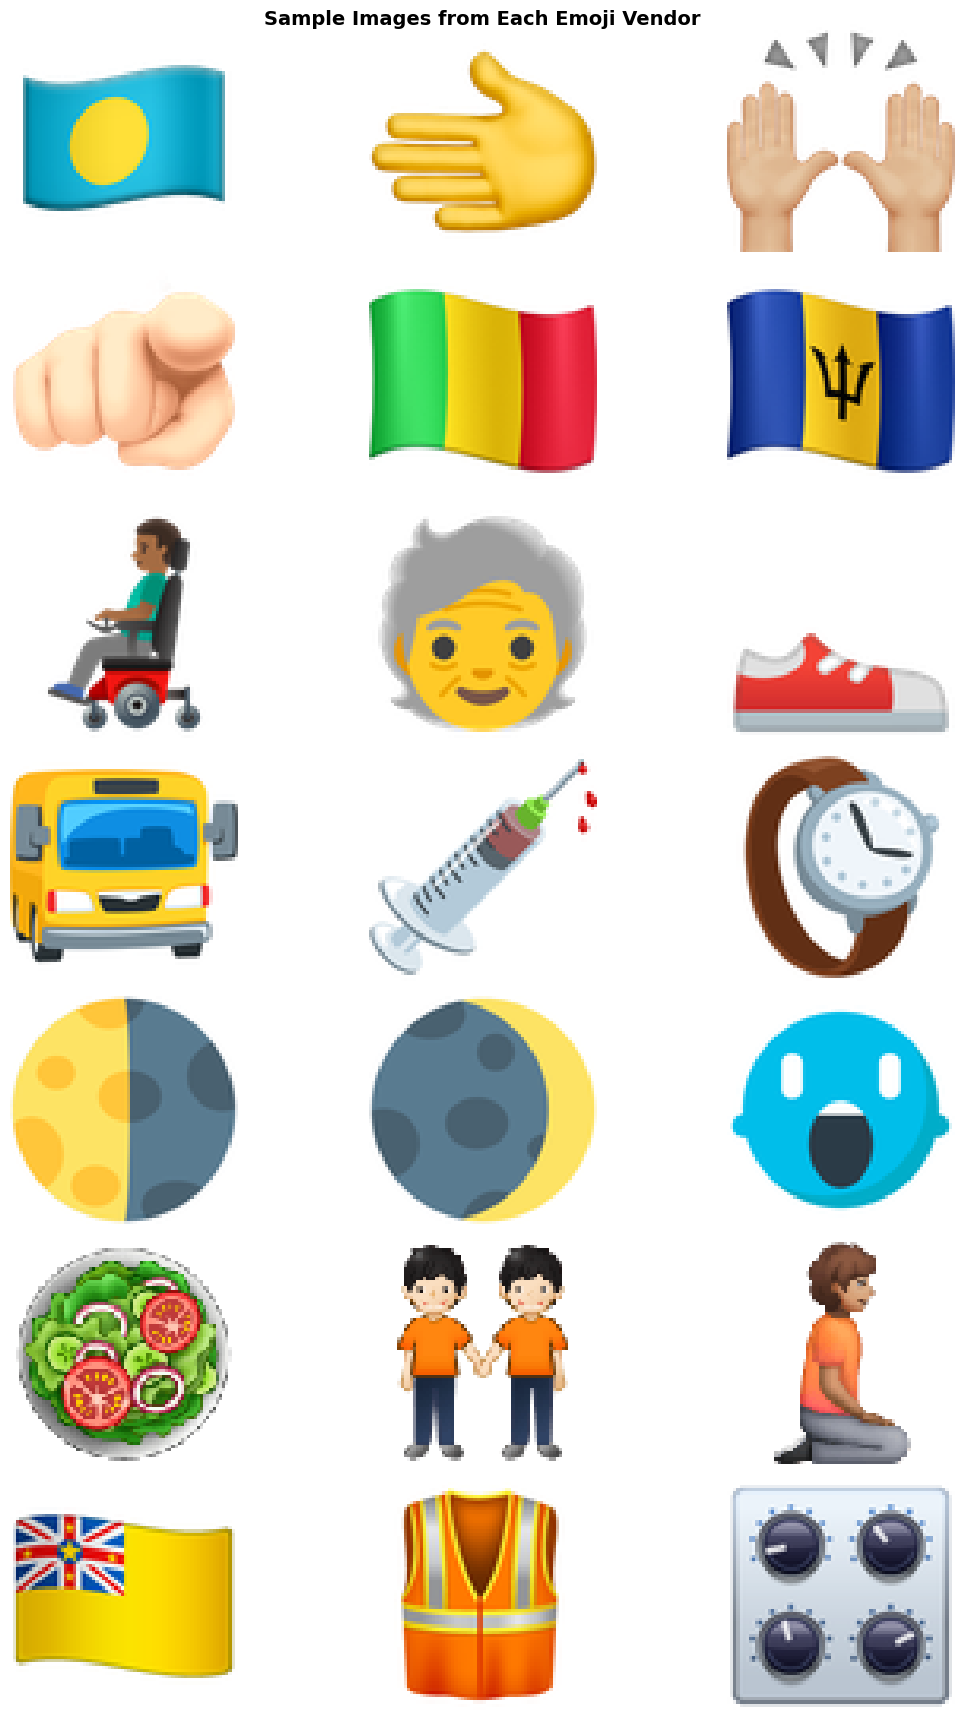

In [11]:
# Visualize sample images from each class
def show_sample_images_per_class(train_files, labels_dict, num_per_class=3):
    """
    Display sample images from each emoji class.
    """
    # Get unique labels
    unique_labels = sorted(set(labels_dict.values()))
    
    fig, axes = plt.subplots(len(unique_labels), num_per_class, 
                             figsize=(12, 2.5 * len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        # Find files for this label
        label_files = [f for f in train_files if labels_dict[Path(f).stem] == label]
        
        # Select random samples
        sample_files = np.random.choice(label_files, 
                                       min(num_per_class, len(label_files)), 
                                       replace=False)
        
        for j, file_path in enumerate(sample_files):
            img = load_single_image(file_path)
            axes[i, j].imshow(img)
            if j == 0:
                axes[i, j].set_ylabel(label, fontsize=12, fontweight='bold')
            axes[i, j].axis('off')
            
        # Fill empty subplots if needed
        for j in range(len(sample_files), num_per_class):
            axes[i, j].axis('off')
    
    plt.suptitle('Sample Images from Each Emoji Vendor', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_sample_images_per_class(train_files, y_train_dct)

In [12]:
# Prepare label encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train_df["Label"])

print("Classes:", label_encoder.classes_)
print("Number of classes:", len(label_encoder.classes_))

# Check class distribution
print("\nClass distribution:")
print(y_train_df["Label"].value_counts())

Classes: ['apple' 'facebook' 'google' 'messenger' 'mozilla' 'samsung' 'whatsapp']
Number of classes: 7

Class distribution:
Label
apple        1924
google       1877
samsung      1790
facebook     1667
whatsapp     1644
messenger     580
mozilla       397
Name: count, dtype: int64


In [13]:
# Split data into training and validation sets
train_files_split, val_files_split = train_test_split(
    train_files, 
    test_size=0.15, 
    random_state=42,
    stratify=[y_train_dct[Path(f).stem] for f in train_files]
)

print(f"Training samples: {len(train_files_split)}")
print(f"Validation samples: {len(val_files_split)}")

Training samples: 8397
Validation samples: 1482


## Model Architecture

In [14]:
def build_cnn_model(input_shape=(72, 72, 3), num_classes=6):
    """
    Build a CNN model for emoji classification.
    Architecture optimized for small emoji images with built-in augmentation.
    """
    model = models.Sequential([
        # Data Augmentation (only active during training)
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build the model
model = build_cnn_model(num_classes=len(label_encoder.classes_))

# Compile with appropriate optimizer and loss
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

C:\Users\19749\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │             

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Data Augmentation

In [15]:
# Data augmentation is now built into the model using Keras 3 preprocessing layers:
# - RandomFlip (horizontal)
# - RandomRotation (~15 degrees)
# - RandomZoom (10%)
# These layers are only active during training, not during inference.

print("✓ Data augmentation is configured in the model architecture")

✓ Data augmentation is configured in the model architecture


In [16]:
# Load training and validation data into memory
print("Loading training data...")
X_train, y_train = create_dataset(train_files_split, y_train_dct, label_encoder)
print(f"Training data loaded: {X_train.shape}")

print("Loading validation data...")
X_val, y_val = create_dataset(val_files_split, y_train_dct, label_encoder)
print(f"Validation data loaded: {X_val.shape}")

Loading training data...
Training data loaded: (8397, 72, 72, 3)
Loading validation data...
Validation data loaded: (1482, 72, 72, 3)


## Training

In [17]:
# Define callbacks for better training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        'best_emoji_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured successfully")

Callbacks configured successfully


In [24]:
# Train the model
BATCH_SIZE = 32
EPOCHS = 50

print("Starting training...")
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training...
Epoch 1/5
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4507 - loss: 1.4767
Epoch 1: val_accuracy improved from 0.39136 to 0.39339, saving model to best_emoji_model.h5


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 149s 140ms/step - accuracy: 0.4460 - loss: 1.4680 - val_accuracy: 0.3934 - val_loss: 1.5505 - learning_rate: 5.0000e-04
Epoch 2/5
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.4810 - loss: 1.3921
Epoch 2: val_accuracy did not improve from 0.39339
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 142s 136ms/step - accuracy: 0.4791 - loss: 1.3989 - val_accuracy: 0.2591 - val_loss: 2.5035 - learning_rate: 5.0000e-04
Epoch 3/5
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5134 - loss: 1.3443
Epoch 3: val_accuracy did not improve from 0.39339
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 194s 185ms/step - accuracy: 0.5148 - loss: 1.3245 - val_accuracy: 0.2679 - val_loss: 2.4210 - learning_rate: 5.0000e-04
Epoch 4/5
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.5163 - loss: 1.3205
Epoch 4: val_accuracy improved from 0.39339 to 0.40756, saving model to best_emoji_model.h5


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 201s 192ms/step - accuracy: 0.5099 - loss: 1.3257 - val_accuracy: 0.4076 - val_loss: 1.6345 - learning_rate: 5.0000e-04
Epoch 5/5
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5275 - loss: 1.2893
Epoch 5: val_accuracy did not improve from 0.40756
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 168s 160ms/step - accuracy: 0.5203 - loss: 1.3034 - val_accuracy: 0.3354 - val_loss: 1.9333 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 1.

Training completed!


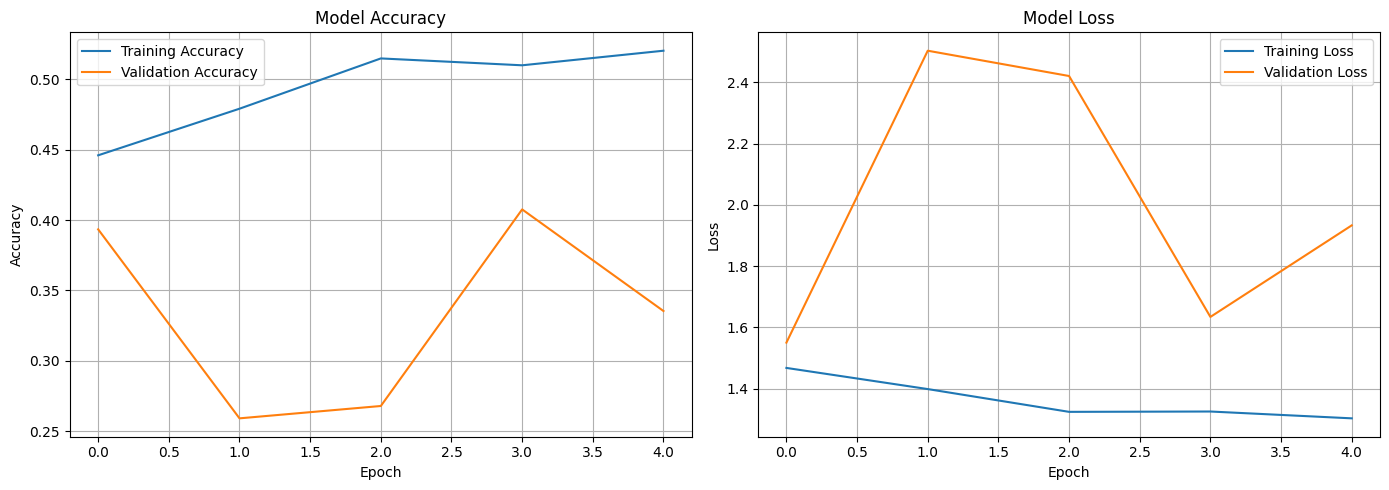


Final Training Accuracy: 0.5203
Final Validation Accuracy: 0.3354
Best Validation Accuracy: 0.4076


In [25]:
# Plot training history
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

## Model Evaluation

In [26]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get predictions on validation set for confusion matrix
val_predictions = model.predict(X_val, verbose=0)
val_pred_labels = np.argmax(val_predictions, axis=1)

Validation Loss: 1.5505
Validation Accuracy: 0.3934


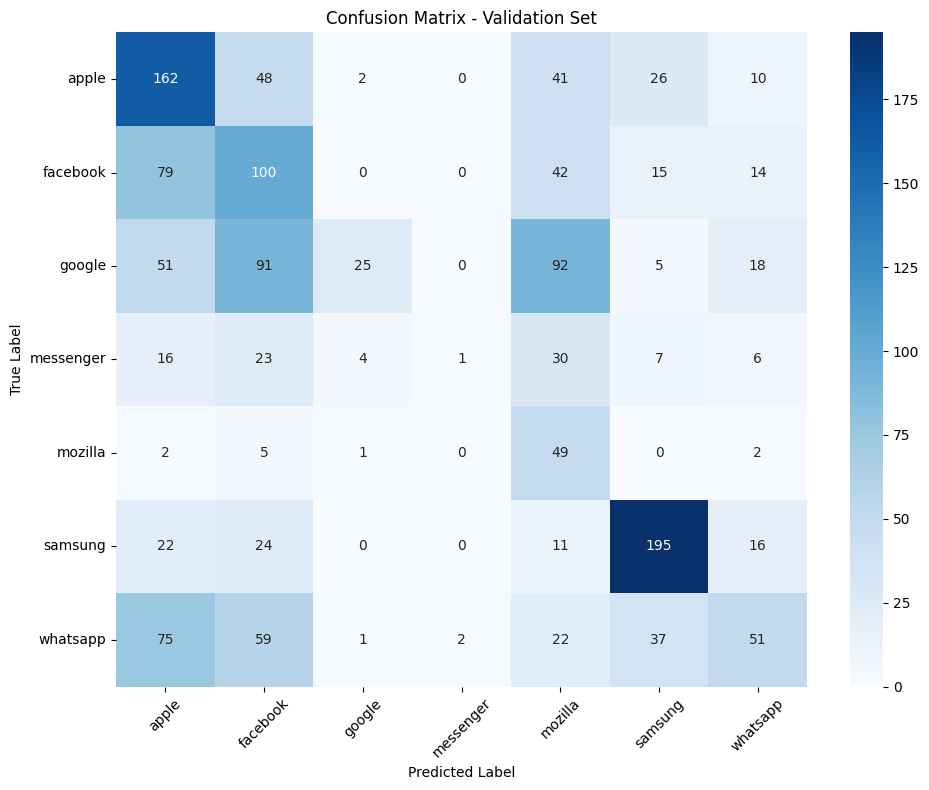


Classification Report:
              precision    recall  f1-score   support

       apple       0.40      0.56      0.47       289
    facebook       0.29      0.40      0.33       250
      google       0.76      0.09      0.16       282
   messenger       0.33      0.01      0.02        87
     mozilla       0.17      0.83      0.28        59
     samsung       0.68      0.73      0.71       268
    whatsapp       0.44      0.21      0.28       247

    accuracy                           0.39      1482
   macro avg       0.44      0.40      0.32      1482
weighted avg       0.49      0.39      0.36      1482



In [27]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_val, val_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, val_pred_labels, 
                          target_names=label_encoder.classes_))

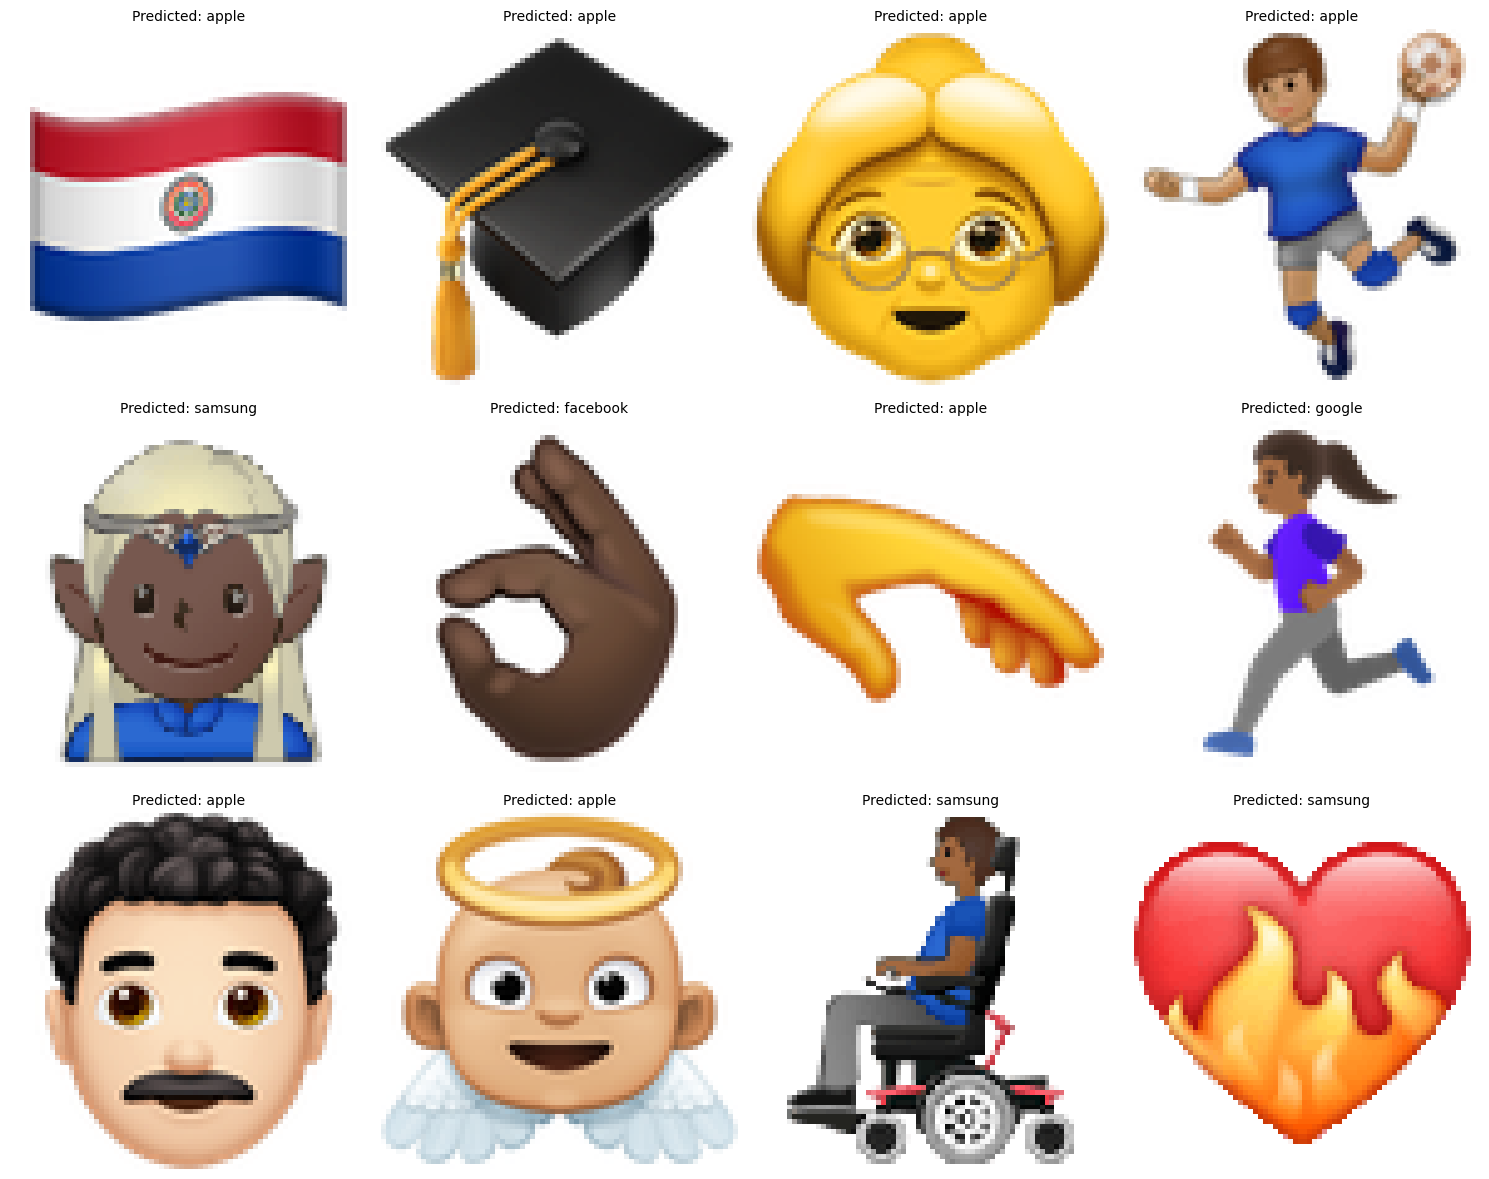

In [28]:
# Visualize some sample predictions
def visualize_predictions(files, predictions, label_encoder, num_samples=12):
    """
    Visualize random sample predictions.
    """
    indices = np.random.choice(len(files), min(num_samples, len(files)), replace=False)
    
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        img = load_single_image(files[idx])
        pred_label = predictions[idx]
        
        axes[i].imshow(img)
        axes[i].set_title(f'Predicted: {pred_label}', fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize validation set predictions
val_predictions_labels = label_encoder.inverse_transform(val_pred_labels)
visualize_predictions(val_files_split, val_predictions_labels, label_encoder)

## Predictions on Test Set

In [29]:
def predict_with_trained_model(model, test_files, label_encoder, batch_size=32):
    """
    Make predictions on test data using the trained model.
    """
    predictions = []
    
    # Process in batches for efficiency
    for i in range(0, len(test_files), batch_size):
        batch_files = test_files[i:i+batch_size]
        batch_images = []
        
        for file_path in batch_files:
            img = load_single_image(file_path)
            batch_images.append(img)
        
        batch_images = np.array(batch_images)
        
        # Get predictions
        batch_preds = model.predict(batch_images, verbose=0)
        batch_labels = np.argmax(batch_preds, axis=1)
        
        # Decode labels
        batch_labels_decoded = label_encoder.inverse_transform(batch_labels)
        predictions.extend(batch_labels_decoded)
    
    return np.array(predictions)

# Make predictions on test set
print("Making predictions on test set...")
y_test_pred = predict_with_trained_model(model, test_files, label_encoder)
print(f"Predictions completed for {len(y_test_pred)} test samples")

# Show prediction distribution
unique, counts = np.unique(y_test_pred, return_counts=True)
print("\nPrediction distribution:")
for label, count in zip(unique, counts):
    print(f"  {label}: {count}")

Making predictions on test set...
Predictions completed for 9879 test samples

Prediction distribution:
  apple: 2630
  facebook: 2240
  google: 166
  messenger: 20
  mozilla: 2000
  samsung: 2127
  whatsapp: 696


In [30]:
test_ids_sr = pd.Series(test_ids, name="Id")
y_test_pred_sr = pd.Series(y_test_pred, name="Label")
submission_df = pd.concat([test_ids_sr, y_test_pred_sr], axis=1)
submission_df.head()

,Id,Label
0,10001,facebook
1,10002,whatsapp
2,10003,samsung
3,10004,apple
4,10005,samsung


## Create Submission File

In [31]:
submission_df.to_csv("submission.csv", index=False)

In [32]:
# Verify submission file
print("Submission file preview:")
print(submission_df.head(10))
print(f"\nTotal submissions: {len(submission_df)}")
print(f"\nSubmission saved to: submission.csv")

# Check for any issues
assert len(submission_df) == len(test_files), "Mismatch in number of predictions!"
assert all(submission_df["Label"].isin(label_encoder.classes_)), "Invalid labels detected!"
print("\n✓ Submission file validated successfully!")

Submission file preview:
      Id     Label
0  10001  facebook
1  10002  whatsapp
2  10003   samsung
3  10004     apple
4  10005   samsung
5  10006   samsung
6  10007    google
7  10008     apple
8  10009     apple
9  10010   samsung

Total submissions: 9879

Submission saved to: submission.csv

✓ Submission file validated successfully!


## Summary

### Model Architecture
- **CNN-based architecture** with 3 convolutional blocks
- Each block contains:
  - 2 Conv2D layers with batch normalization
  - MaxPooling for downsampling
  - Dropout for regularization
- Dense layers with 256 and 128 neurons
- **Total classes**: 6 emoji vendors (apple, facebook, google, messenger, samsung, whatsapp)

### Training Strategy
- **Data augmentation**: rotation, shifts, zoom, horizontal flip
- **Train/validation split**: 85/15 stratified split
- **Optimizer**: Adam with learning rate 0.001
- **Callbacks**: 
  - Early stopping (patience=10)
  - Learning rate reduction on plateau
  - Model checkpointing

### Key Features
- Proper image preprocessing (RGBA→RGB, resizing, normalization)
- Label encoding for multi-class classification
- Comprehensive evaluation metrics (confusion matrix, classification report)
- Visualization of training progress and predictions

### Next Steps for Improvement
1. **Transfer Learning**: Use pre-trained models (MobileNet, EfficientNet)
2. **Ensemble Methods**: Combine multiple models
3. **Advanced Augmentation**: Use techniques like mixup, cutmix
4. **Hyperparameter Tuning**: Optimize learning rate, batch size, architecture
5. **Cross-Validation**: Use K-fold for more robust evaluation